In [131]:
import tensorflow as tf
import numpy as np
from datasets import load_dataset
from tensorflow.keras.applications.resnet50 import preprocess_input

In [132]:
dataset = load_dataset("sleepyCoder23/facial_expression_dataset")

Using the latest cached version of the dataset since sleepyCoder23/facial_expression_dataset couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\vsmmc\.cache\huggingface\datasets\sleepyCoder23___facial_expression_dataset\default\0.0.0\e4c63ee61a6b556eb2836bc59a17607741e534ba (last modified on Tue Mar 25 06:39:17 2025).


In [133]:
info = {
    "features": dataset["train"].features,  
    "splits": list(dataset.keys()), 
    "num_classes": len(set(dataset["train"]["label"])) 
}

print(info)

{'features': {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['happy_face', 'neutral_face', 'angry_face', 'fear_face', 'sad_face'], id=None)}, 'splits': ['train', 'val', 'test'], 'num_classes': 5}


In [134]:
train_images = np.array([np.array(ex["image"].resize((224, 224))) for ex in dataset["train"]])
train_labels = np.array(dataset["train"]["label"])

val_images = np.array([np.array(ex["image"].resize((224, 224))) for ex in dataset["val"]])
val_labels = np.array(dataset["val"]["label"])

test_images = np.array([np.array(ex["image"].resize((224, 224))) for ex in dataset["test"]])
test_labels = np.array(dataset["test"]["label"])

In [135]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"Sample Label: {train_labels[:5]}")

Train Images Shape: (513, 224, 224, 3)
Train Labels Shape: (513,)
Test Images Shape: (75, 224, 224, 3)
Test Labels Shape: (75,)
Sample Label: [0 0 0 0 0]


In [136]:
train_images = np.array(train_images, dtype=np.float32) 
test_images = np.array(test_images, dtype=np.float32) 

train_labels = np.array(train_labels, dtype=np.float32) 
test_labels = np.array(test_labels, dtype=np.float32) 

In [137]:
train_images = preprocess_input(train_images)
val_images = preprocess_input(val_images)
test_images = preprocess_input(test_images)

In [138]:

# Define Input Layer
inputs = tf.keras.Input(shape=(224, 224, 3))

# Apply Data Augmentation
x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)

# Load Pre-trained ResNet50 (Without Top Layers)
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False)

# Pass Augmented Images Through ResNet50
x = base_model(x, training=False)  # Freeze ResNet50's weights

# Add Custom Fully Connected Layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(5, activation="softmax")(x)

# Define Model
model = tf.keras.Model(inputs=inputs, outputs=output)



In [139]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)  # Lower LR for fine-tuning


model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])


history = model.fit(train_images, train_labels,  
                    epochs=10,  
                    validation_data=(val_images, val_labels), 
                    batch_size=32)



Epoch 1/10


In [ ]:
model.evaluate(test_images, test_labels)


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6095 - loss: 2.9864e-09


[3.1789142429516914e-09, 0.4533333480358124]

np.float32(0.0)

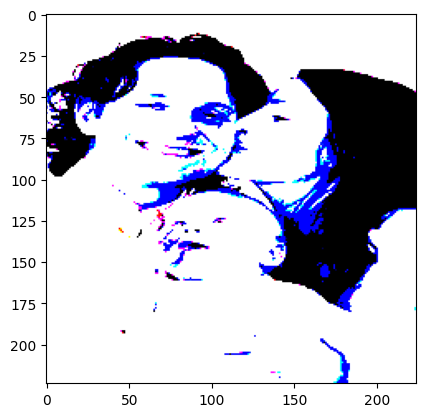

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(test_images[10])
test_labels[10]